In [1]:
import pandas as pd

df = pd.read_csv('data_preprocessed.csv')
df.head(5)

,category,article
0,COMEDY,of the funniest tweets about cats and dogs thi...
1,PARENTING,the funniest tweets from parents this week sep...
2,SPORTS,maury wills basestealing shortstop for dodgers...
3,ENTERTAINMENT,golden globes returning to nbc in january afte...
4,POLITICS,biden says us forces would defend taiwan if ch...


In [2]:
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = df.dropna()
df = df.astype(str)

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Function to convert NLTK tag to WordNet tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(text)) # Tokenize text and get word parts of speech
    lemmatized_words = []

    for word, tag in word_pos_tags:
        wntag = get_wordnet_pos(tag)
        if wntag is None:  # if no tag, consider it a noun
            lemmatized_words.append(lemmatizer.lemmatize(word))
        else:
            lemmatized_words.append(lemmatizer.lemmatize(word, pos=wntag))

    return ' '.join(lemmatized_words)

# Apply lemmatization to each article
df['article'] = df['article'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
def prepare_tokenizer(texts, unknown_token="<UNK>", max_length=200):
    tokenizer = Tokenizer(oov_token=unknown_token)
    tokenizer.fit_on_texts(texts)
    return tokenizer, max_length

In [6]:
def encode_sequences(tokenizer, texts, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='pre')
    return padded_sequences

In [7]:
def encode_labels(labels):
    label_indices = labels.astype('category').cat.codes
    return to_categorical(label_indices)

In [8]:
def split_dataset(X, Y, test_size=0.2, random_state=50):
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)


In [31]:
def load_glove_embeddings(glove_file_path, embedding_dim, word_index):
    embeddings_index = {}

    # Load GloVe model
    with open(glove_file_path, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [20]:

def build_lstm_model(embedding_matrix, sequence_length, num_classes, lstm_units=150):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=sequence_length, trainable=False))

    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))

    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units)))

    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
tokenizer, max_length = prepare_tokenizer(df['article'])
X = encode_sequences(tokenizer, df['article'], max_length)
Y = encode_labels(df['category'])

In [23]:
X_train, X_test, y_train, y_test = split_dataset(X, Y)


In [24]:
embedding_matrix = load_glove_embeddings('glove.6B.200d.txt', 200, tokenizer.word_index)

In [26]:
from keras.callbacks import EarlyStopping
batch_size = 32
epoch_num = 10
model = build_lstm_model(embedding_matrix, max_length, y_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
2780/2780 [==============================] - 65s 20ms/step - loss: 0.9748 - accuracy: 0.7243 - val_loss: 0.7604 - val_accuracy: 0.7802
Epoch 2/10
2780/2780 [==============================] - 50s 18ms/step - loss: 0.7228 - accuracy: 0.7961 - val_loss: 0.7032 - val_accuracy: 0.7933
Epoch 3/10
2780/2780 [==============================] - 52s 19ms/step - loss: 0.6479 - accuracy: 0.8168 - val_loss: 0.6912 - val_accuracy: 0.7974
Epoch 4/10
2780/2780 [==============================] - 53s 19ms/step - loss: 0.5881 - accuracy: 0.8342 - val_loss: 0.6829 - val_accuracy: 0.8017
Epoch 5/10
2780/2780 [==============================] - 49s 18ms/step - loss: 0.5380 - accuracy: 0.8487 - val_loss: 0.6853 - val_accuracy: 0.8021
Epoch 6/10
2780/2780 [==============================] - 50s 18ms/step - loss: 0.4929 - accuracy: 0.8631 - val_loss: 0.6972 - val_accuracy: 0.8020
Epoch 7/10
2780/2780 [==============================] - 49s 18ms/step - loss: 0.4495 - accuracy: 0.8748 - val_loss: 0.7302 -

869/869 [==============================] - 8s 7ms/step


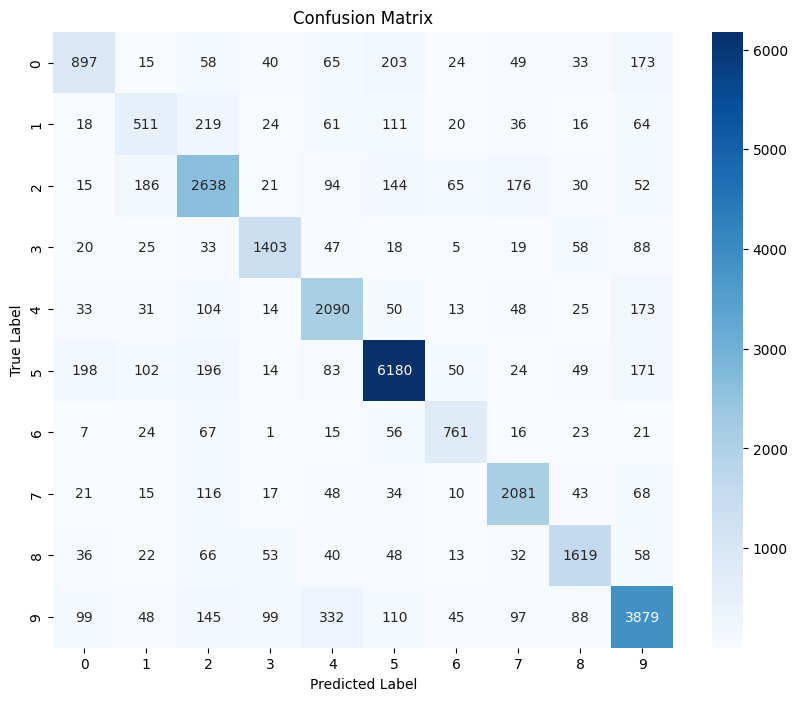

In [27]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [28]:
# Accuracy Score
import sklearn.metrics
accuracy_score = sklearn.metrics.accuracy_score(y_true, y_pred_classes)
print("accuracy_score of test set:", accuracy_score)

accuracy_score of test set: 0.7936319481921209


In [29]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62      1557
           1       0.52      0.47      0.50      1080
           2       0.72      0.77      0.75      3421
           3       0.83      0.82      0.82      1716
           4       0.73      0.81      0.77      2581
           5       0.89      0.87      0.88      7067
           6       0.76      0.77      0.76       991
           7       0.81      0.85      0.83      2453
           8       0.82      0.81      0.82      1987
           9       0.82      0.78      0.80      4942

    accuracy                           0.79     27795
   macro avg       0.76      0.75      0.75     27795
weighted avg       0.79      0.79      0.79     27795

